In [ ]:
import pickle
from collections import namedtuple
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from gym.wrappers import Monitor
from matplotlib.lines import Line2D

Environment defined and tuples for training records and transitions are created

In [ ]:
env = gym.make("Pendulum-v0")
observation_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0]
TrainingRecord = namedtuple('TrainingRecord', ['epoch', 'reward', 'empowerment'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

Memory buffer for DDPG training

In [ ]:
class Memory():
    data_pointer = 0
    isfull = False
    def __init__(self, capacity):
        self.memory = np.empty(capacity, dtype=object)
        self.capacity = capacity
    def update(self, transition):
        self.memory[self.data_pointer] = transition
        self.data_pointer += 1
        if self.data_pointer == self.capacity:
            self.data_pointer = 0
            self.isfull = True
    def sample(self, batch_size):
        return np.random.choice(self.memory, batch_size)

Hyperparameters

In [ ]:
GAMMA = 0.9
LOG_INTERVAL = 10
BATCH_SIZE = 128
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
EPOCHS = 100
M = 10
T = 200
BETA = 1
PATH = "saved_weights_{}"

Predefined pendulum dynamics model, same as in Pendulum-v0 gym environment

In [ ]:
class Dynamics():
    def __init__(self, g=10.0):
        self.max_speed=8
        self.max_torque=2.
        self.dt=.05
        self.g = g
        self.m = 1.
        self.l = 1.
        high = np.array([1., 1., self.max_speed])
    def angle_normalize(self, x):
        return (((x + np.pi) % (2 * np.pi)) - np.pi)

    def _get_obs(self):
        sin_theta, cos_theta, thetadot = self.state
        return np.array([sin_theta, cos_theta, thetadot],dtype=float)

    def step(self,u, state):
        th = np.arctan2(state[1], state[0])
        thdot = state[2]
        g = self.g
        m = self.m
        l = self.l
        dt = self.dt
        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        costs = self.angle_normalize(th)**2 + .1*thdot**2 + .001*(u**2)

        newthdot = thdot + (-3*g/(2*l) * np.sin(th + np.pi) + 3./(m*l**2)*u) * dt
        newth = th + newthdot*dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed) #pylint: disable=E1111

        self.state = np.array([np.cos(newth), np.sin(newth), newthdot],dtype=float)
        return self._get_obs(), -costs, False, {}

Source Network, gets an observation for the state (s) and outputs the distribution and a sample for a latent action variable a ~ w(a|s). It's a probability distribution that addresses the likelihood for an action given a certain state.

In [ ]:
class Source(nn.Module):
    def __init__(self, n_actions, n_states):
        super().__init__()

        self.source_mu = nn.Sequential(
            nn.Linear(n_states, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, n_actions)
        )
        self.source_log_var = nn.Sequential(
            nn.Linear(n_states, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)+ 1e-5
        eps = torch.rand_like(std)
        return mu + std*eps

    def forward(self, s):
        s = s.float().unsqueeze(0)
        mu = self.source_mu(s)
        log_var = self.source_log_var(s)
        act = self.reparameterize(mu, log_var)
        return act, mu, log_var

Planning Network, gets an observation for the state (s) and the dynamics model prediction for the next state (s'=dynamics.step(a,s)) and outputs the distribution and a sample for a latent action variable a ~ p(a|s,s')

In [ ]:
class Planning(nn.Module):
    def __init__(self, n_actions, n_states):
        super().__init__()
        self.fcs = nn.Linear(n_states, 128)
        self.fcs_ = nn.Linear(n_states, 128)
        self.planning_mu = nn.Sequential(
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, n_actions)
        )
        self.planning_log_var = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)+ 1e-5
        eps = torch.rand_like(std)
        return mu + std*eps

    def forward(self, s, s_next):
        s = s.float().unsqueeze(0)
        s_next = s_next.float().unsqueeze(0)
        s = F.relu(self.fcs(s))
        s_next = F.relu(self.fcs_(s_next))
        s_cat = torch.cat([s, s_next], dim=-1)
        mu = self.planning_mu(s_cat)
        log_var = self.planning_log_var(s_cat)
        act = self.reparameterize(mu, log_var)
        return act, mu, log_var

Function that computes the log-likelihood for a given action a and the mean (mu) and variance (log_var) parameters that model the probability distribution.

In [ ]:
def ll_gaussian(act, mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (act-mu)**2

Definition of Actor, Critic and Agent for the DDPG algorithm.

In [ ]:
class ActorNet(nn.Module):
    def __init__(self, n_actions, n_states):
        super(ActorNet, self).__init__()
        self.fc = nn.Linear(n_states, 100)
        self.mu_head = nn.Linear(100, n_actions)
    def forward(self, s):
        x = F.relu(self.fc(s))
        u = 2.0 * torch.tanh(self.mu_head(x))
        return u

In [ ]:
class CriticNet(nn.Module):
    def __init__(self, n_actions, n_states):
        super(CriticNet, self).__init__()
        self.fc = nn.Linear(n_actions + n_states, 100)
        self.v_head = nn.Linear(100, n_actions)
    def forward(self, s, a):
        x = F.relu(self.fc(torch.cat([s, a], dim=1)))
        state_value = self.v_head(x)
        return state_value

In [ ]:
class Agent():

    max_grad_norm = 0.5
    def __init__(self, n_actions, n_states):
        self.training_step = 0
        self.var = 1.
        self.eval_cnet, self.target_cnet = CriticNet(n_actions, n_states).float(), CriticNet(n_actions, n_states).float()
        self.eval_anet, self.target_anet = ActorNet(n_actions, n_states).float(), ActorNet(n_actions, n_states).float()
        self.optimizer_c = optim.Adam(self.eval_cnet.parameters(), lr=1e-3)
        self.optimizer_a = optim.Adam(self.eval_anet.parameters(), lr=3e-4)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        mu = self.eval_anet(state)
        dist = Normal(mu, torch.tensor(self.var, dtype=torch.float))
        action = dist.sample()
        action.clamp(-2.0, 2.0)
        return (action.item(),)

    def update(self, transitions):
        self.training_step += 1
        s = torch.tensor([t.s for t in transitions], dtype=torch.float)
        a = torch.tensor([t.a for t in transitions], dtype=torch.float).view(-1, 1)
        r = torch.tensor([t.r for t in transitions], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in transitions], dtype=torch.float)

        with torch.no_grad():
            q_target = r + GAMMA * self.target_cnet(s_, self.target_anet(s_))
        q_eval = self.eval_cnet(s, a)

        self.optimizer_c.zero_grad()
        self.optimizer_a.zero_grad()

        c_loss = F.smooth_l1_loss(q_eval, q_target)
        a_loss = -self.eval_cnet(s, self.eval_anet(s)).mean()
        c_loss.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(self.eval_cnet.parameters(), self.max_grad_norm)
        self.optimizer_c.step()
        a_loss.backward(retain_graph=True )
        nn.utils.clip_grad_norm_(self.eval_anet.parameters(), self.max_grad_norm)
        self.optimizer_a.step()

        if self.training_step % 200 == 0:
            self.target_cnet.load_state_dict(self.eval_cnet.state_dict())
        if self.training_step % 201 == 0:

            self.target_anet.load_state_dict(self.eval_anet.state_dict())
        self.var = max(self.var * 0.999, 0.01)

        return q_eval.mean().item()

Initialize networks 

In [ ]:
training_records = []
running_reward, running_q = -1000, 0
memory = Memory(2000)
agent = Agent(n_actions=1, n_states=3)
dynamics = Dynamics()
source_network = Source(n_actions=1, n_states=3)
planning_network = Planning(n_actions=1, n_states=3)
source_optimizer = optim.Adam(source_network.parameters(), lr=1e-4)
planning_optimizer = optim.Adam(planning_network.parameters(), lr=1e-4)
epoch = 0

Implementation of algorithm according to Karl et al. An epoch is understood as M trajectories of T steps.
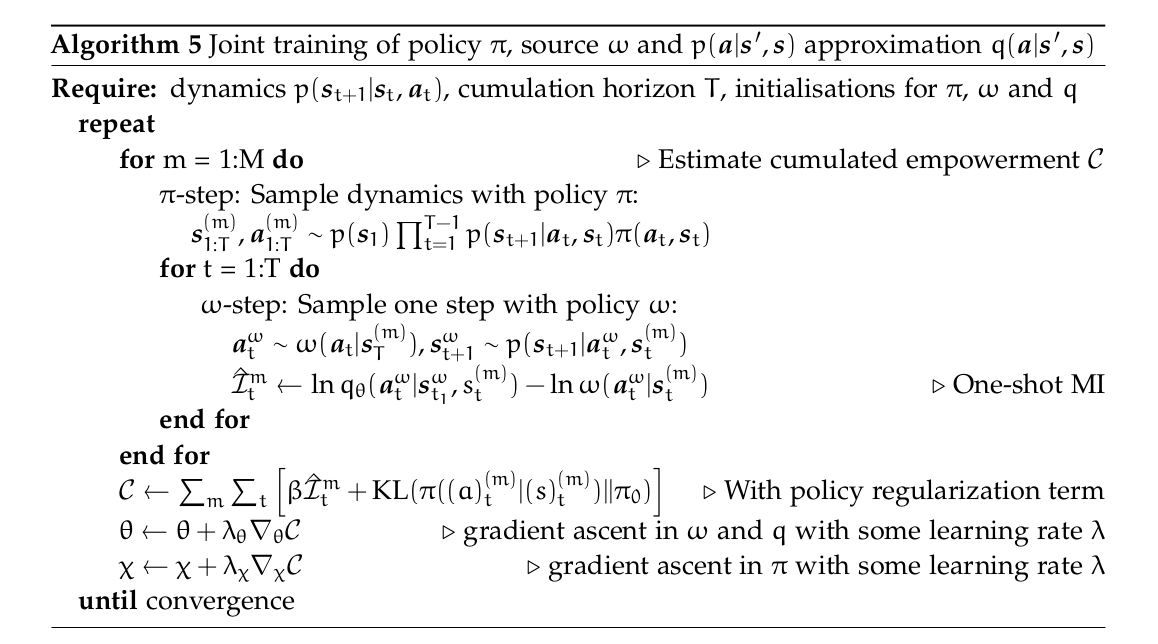

In [ ]:
while epoch < EPOCHS:
    empowerment = 0
    prev_best_reward = -2000
    source_optimizer.zero_grad()
    planning_optimizer.zero_grad()
    trajec_mi = []
    for m in range(M):
        score = 0
        state = env.reset()
        insta_mi = []
        for t in range(T):
            action = agent.select_action(state)
            state, reward, done, _ = env.step(action)
            state_ = np.asarray(dynamics.step(action, state))[0]
            state_tensor = Variable(torch.from_numpy(state), requires_grad=True)
            state_tensor_ = Variable(torch.from_numpy(state_), requires_grad=True)
            action_tensor = Variable(torch.tensor(action), requires_grad=True)
            source_action, source_mean, source_log_var = source_network(state_tensor)
            source_state_ = np.asarray(dynamics.step((source_action.item(),), state))[0]
            source_state_tensor_ = Variable(torch.from_numpy(source_state_), requires_grad=True)
            planning_action, planning_mean, planning_log_var = planning_network(state_tensor, source_state_tensor_)
            MI = ll_gaussian(source_action, planning_mean, planning_log_var) - ll_gaussian(source_action, source_mean, source_log_var)
            insta_mi.append(BETA*MI)
            score += reward
            memory.update(Transition(state, action, (reward + 8) / 8, state_))
            if memory.isfull:
                transitions = memory.sample(16)
                q = agent.update(transitions)
                running_q = 0.99 * running_q + 0.01 * q
        running_reward = running_reward * 0.9 + score * 0.1
        if running_reward > -200 and running_reward > prev_best_reward:
            prev_best_reward = running_reward
            print("Better policy found, reward is now {}!".format(running_reward))
            torch.save(agent.eval_anet.state_dict(), 'ddpg_anet_params.pkl')
            torch.save(agent.eval_cnet.state_dict(), 'ddpg_cnet_params.pkl')
            with open('ddpg_training_records.pkl', 'wb') as f:
                pickle.dump(training_records, f)
        trajec_mi.append(sum(insta_mi))
    empowerment = -sum(trajec_mi)/(M*T)
    empowerment.backward(retain_graph=True)
    source_optimizer.step()
    planning_optimizer.step()
    training_records.append(TrainingRecord(epoch, running_reward, -empowerment.item()))
    print('Epoch {}\tAverage score: {:.2f}\tAverage Q: {:.2f}\tEmpowerment: {:.2f}'.format(
                epoch, running_reward, running_q, -empowerment.item()))

    dummy_state = np.array([1, 0, 0])
    dummy_action = (0.0,)
    dummy_state_ = np.asarray(dynamics.step(dummy_action, dummy_state)[0])
    dummy_state_tensor = Variable(torch.from_numpy(dummy_state))
    dummy_state_tensor_ = Variable(torch.from_numpy(dummy_state_))
    dummy_source_action, dummy_source_mean, dummy_source_log_var = source_network(dummy_state_tensor)
    dummy_planning_action, dummy_planning_mean, dummy_planning_log_var = planning_network(dummy_state_tensor, dummy_state_tensor_)
    print('Test --- state: {}, action:{}, next_state: {},'
          '\n source_action: {}, source_mean: {}, source source_log_var: {}'
          ' \n planning_action: {}, planning_mean: {}, planning_log_var: {}'
          .format(dummy_state, dummy_action[0], dummy_state_,
                  dummy_source_action.item(), dummy_source_mean.item(), dummy_source_log_var.item(),
                  dummy_planning_action.item(), dummy_planning_mean.item(), dummy_planning_log_var.item()))

    epoch += 1
env.close()

In [ ]:
plt.plot([r.epoch for r in training_records], [r.reward for r in training_records])
plt.title('DDPG')
plt.xlabel('Epoch')
plt.ylabel('Moving averaged episode reward')
plt.savefig("ddpg.png")
plt.show()

plt.plot([r.epoch for r in training_records], [r.empowerment for r in training_records])
plt.title('DDPG')
plt.xlabel('Epoch')
plt.ylabel('Epoch Empowerment')
plt.savefig("ddpgempowerment.png")
plt.show()